In [28]:
# All imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import norm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.cluster import KMeans, MiniBatchKMeans

In [29]:
# read previous data:
df = pd.read_pickle('step2_df.pk')

In [30]:
# create the skills array
skills_data = []
for i, r in df.iterrows():
    skills_data.extend(r['bullets'])

In [31]:
# get the vectorizer
tfidfvectorizer = TfidfVectorizer(stop_words='english')

# create the tfidf matrix or our skills
tfidf_skills_matrix = tfidfvectorizer.fit_transform(skills_data)

# get the words of the skills
skills_words = tfidfvectorizer.get_feature_names()

In [32]:
# get the svd for the skills
svd_skills = TruncatedSVD(n_components=100, random_state=42)

svd_skills_result = svd_skills.fit_transform(tfidf_skills_matrix)

# normalize the svd results to improve results later
svd_skills_norm_result = normalize(svd_skills_result)

In [33]:
# Clustering the svd result
kcluster_model = KMeans(n_clusters = 20)
kclusters_skills = kcluster_model.fit_predict(svd_skills_norm_result)
df_clusters_skills = pd.DataFrame({'Index': range(kclusters_skills.size), 'Cluster': kclusters_skills})

In [34]:
# function to rank words
def rank_words_by_tfidf(indices, word_list=skills_words):
    summed_tfidf = np.asarray(tfidf_skills_matrix[indices].sum(axis=0))[0]
    data = {'Word': word_list,
            'Summed TFIDF': summed_tfidf}
    return pd.DataFrame(data).sort_values('Summed TFIDF', ascending=False)

In [35]:
# functions to create custom word clours 
def cluster_to_image(df_cluster, max_words=15):
    indices = df_cluster.Index.values
    df_ranked_words = rank_words_by_tfidf(indices)[:max_words]
    words_to_score = {word: score
                      for word, score in df_ranked_words[:max_words].values}
    cloud_generator = WordCloud(background_color='white',
                                color_func=_color_func,
                                random_state=1)
    wordcloud_image = cloud_generator.fit_words(words_to_score)
    return wordcloud_image

def _color_func(*args, **kwargs):
    return np.random.choice(['black', 'blue', 'teal', 'purple', 'brown'])

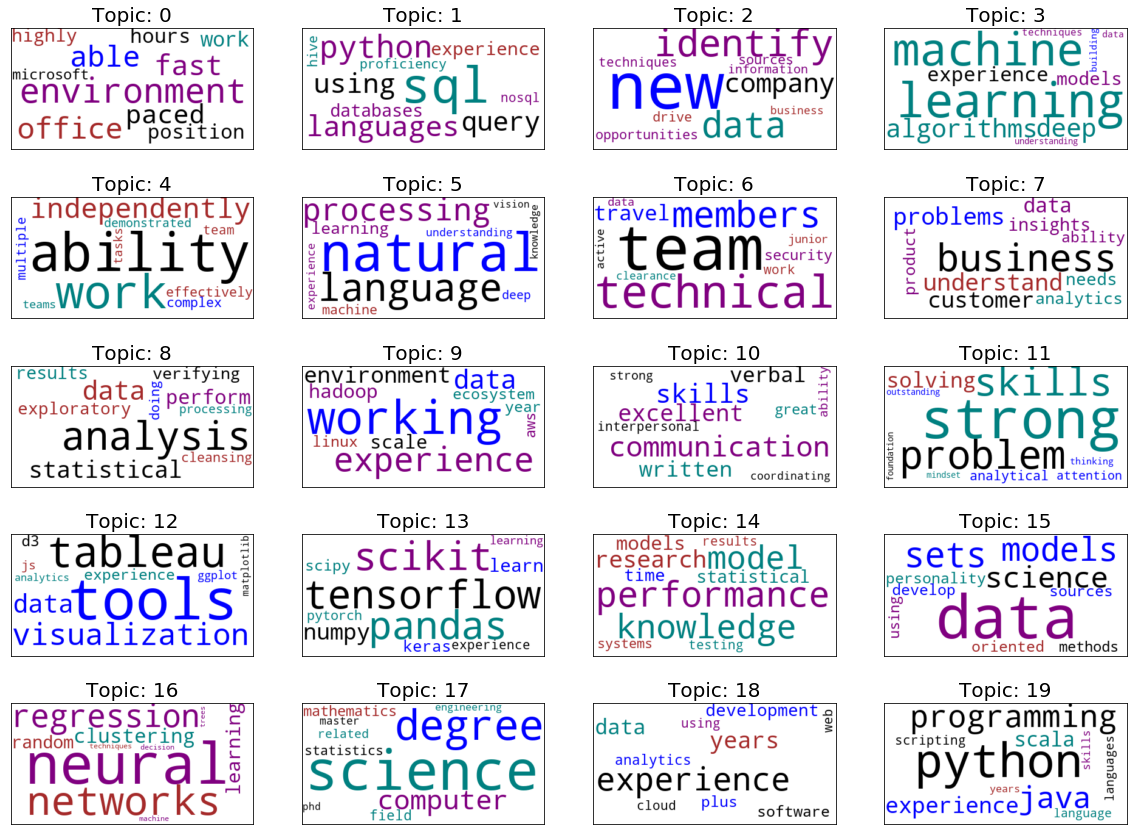

In [36]:
# final word clouds
figure, axes = plt.subplots(5, 4, figsize=(20, 15))
cluster_groups = list(df_clusters_skills.groupby('Cluster'))
for r in range(5):
    for c in range(4):
        _, df_cluster = cluster_groups.pop(0)
        wordcloud_image = cluster_to_image(df_cluster, max_words=10)
        ax = axes[r][c]
        ax.imshow(wordcloud_image,
                  interpolation="bilinear")
        ax.set_title(f'Topic: {df_cluster.Cluster.values[0]}', fontsize=20)
        ax.set_xticks([])
        ax.set_yticks([])


plt.show()